# RNN-Autoencoder

Попытка использовать большое количество оригиналов для обучения без учителя. С этой целью используется модель автоэнкодера с RNN энкодером и декодером. В качестве входных данных эмбеддинги, полученные с помощью ResNet 34.

Гипотеза: При реконструкции атак ошибка должна быть выше (аномалии).

Улучшение: Предобученная ResNet 34 (например, часть CNN из CNN_Transformer)

## Dependences

In [ ]:
!nvidia-smi

Wed Apr 28 21:59:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     6W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ffmpeg-python

In [ ]:
import os
import cv2
import ffmpeg
from PIL import Image
import numpy as np
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import requests
import math
import glob
import random
from random import choice
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%time
# !gdown --id 1SB0qwhhlEFH1DZNeaFrsGEbYfWerRxWc

In [ ]:
%%time
!tar xzf '/content/drive/MyDrive/combined_ds.tar.gz' #combined_ds.tar.gz #

CPU times: user 1.49 s, sys: 228 ms, total: 1.72 s
Wall time: 5min 9s


In [ ]:
dir_1 = '/content/irina/attack/opt/labeler/static/video/api'
images_1 = glob.glob(dir_1 + '/*.*') + glob.glob(dir_1 + '/*/*.*')
len(images_1)

48

In [ ]:
dir_2 = '/content/irina/original/opt/labeler/static/video/api'
images_2 = glob.glob(dir_2 + '/*.*') + glob.glob(dir_2 + '/*/*.*')
len(images_2)

5092

In [ ]:
train_images = images_2[:-48]
print(len(train_images))

5044


In [ ]:
val_images = images_2[-48:]
print(len(val_images))

48


In [ ]:
val_images_1 = images_1
print(len(val_images_1))

48


## Preprocessing

In [ ]:
h, w = 224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
def check_rotation(path_video_file):

    meta_dict = ffmpeg.probe(path_video_file)

    rotateCode = None
    try:
        if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
            rotateCode = cv2.ROTATE_90_CLOCKWISE
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
            rotateCode = cv2.ROTATE_180
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    except: 
        pass
        
    return rotateCode

In [ ]:
def correct_rotation(frame, rotateCode):  
    return cv2.rotate(frame, rotateCode)

In [ ]:
def get_frames(filename, n_max=float('inf')):
    
    frames = []
    v_cap = cv2.VideoCapture(filename)
    rotateCode = check_rotation(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    n_frames = min(v_len, n_max)
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if rotateCode is not None:
                frame = correct_rotation(frame, rotateCode)  
            frames.append(frame)

    v_cap.release()

    return frames, len(frames)

In [ ]:
def transform_frames(frames, train=True):

    img_transforms_0 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_1 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_2 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_3 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    
    img_transforms = [img_transforms_0, 
                      img_transforms_1, 
                      img_transforms_2, 
                      img_transforms_3] 
    if train:
        img_transform = random.choice(img_transforms)
    else:
        img_transform = img_transforms_0
    
    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)       
        frame_tr = img_transform(frame)
        frames_tr.append(frame_tr)
        
    imgs_tensor = torch.stack(frames_tr)    

    return imgs_tensor

## Model

In [ ]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(EncoderRNN, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.2, bidirectional=bidirectional)

    def forward(self, x, lens):

        packed_frames_emb = nn.utils.rnn.pack_padded_sequence(x, lens, enforce_sorted=False)
        packed_out, h = self.lstm(packed_frames_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out)

        return out


class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, num_layers, bidirectional=False):
        super(DecoderRNN, self).__init__()

        self.lstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True,
                            dropout=0.2, bidirectional=bidirectional)
        
    def forward(self, x, lens):

        packed_frames_emb = nn.utils.rnn.pack_padded_sequence(x, lens, enforce_sorted=False)
        packed_out, h = self.lstm(packed_frames_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out)

        return out


class AutoEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(AutoEncoderRNN, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, bidirectional)
        self.decoder = DecoderRNN(hidden_size, input_size, num_layers, bidirectional)

    def forward(self, x, lens):
        encoded_x = self.encoder(x, lens)
        decoded_x = self.decoder(encoded_x, lens)

        return decoded_x

In [ ]:
class CNNEncoder(nn.Module):

    def __init__(self, pretrained=True):
        super(CNNEncoder, self).__init__()
        
        resnet = models.resnet34(pretrained=pretrained) 

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, image):

        # (batch_size, 512, 1, 1)
        out = self.resnet(image)

        return out.view(-1, 512) 

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):

        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x + self.scale * self.pe[:x.size(0), :]

        return self.dropout(x)


class CNN_Transformer(nn.Module):

    def __init__(self, num_classes, nlayers, hidden, nhead, dim_feedforward, 
                 dropout=0, activation='relu'):

        super(CNN_Transformer, self).__init__()

        self.hidden = hidden
        
        # CNN
        self.cnn = CNNEncoder()
        self.conv = nn.Conv2d(512, hidden, 1)

        # Transformer
        self.pos = PositionalEncoding(hidden) 
        encoder_layer = nn.TransformerEncoderLayer(hidden, 
                                                   nhead, 
                                                   dim_feedforward, 
                                                   dropout, 
                                                   activation)
        encoder_norm = nn.LayerNorm(hidden)
        self.transformer = nn.TransformerEncoder(encoder_layer, 
                                                 nlayers, 
                                                 encoder_norm)

        # Classifier
        self.dropout= nn.Dropout(dropout)
        self.fc = nn.Linear(hidden*1, num_classes)

    def forward(self, frames, f_lens, mask):
        
        bs, s, c, height, width = frames.shape
        frames_emb = torch.zeros(s, bs, self.hidden).to(device)

        for i in range(s):
            img_emb = self.cnn(frames[:, i])
            img_emb = torch.relu(self.conv(img_emb))
            frames_emb[i] = img_emb.view(bs, -1)

        frames_emb = self.pos(frames_emb) 
        out = self.transformer(src=frames_emb, src_key_padding_mask=mask)
        out = self.fc(self.dropout(torch.max(out, 0)[0]))
 
        return out 

## Configuration

In [ ]:
cnn = CNNEncoder()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
cnn = cnn.to(device)

In [ ]:
model_clf = CNN_Transformer(num_classes=2,
                                nlayers=1,
                                hidden=32,
                                nhead=4,
                                dim_feedforward=128,
                                dropout=0.5)

In [ ]:
model_clf.load_state_dict(torch.load('/content/v2_CNN_Transformer_best_score.pt'))

<All keys matched successfully>

In [ ]:
cnn.load_state_dict(model_clf.cnn.state_dict())

<All keys matched successfully>

In [ ]:
cnn = cnn.to(device)

In [ ]:
model = AutoEncoderRNN(input_size=512, hidden_size=32, num_layers=2)

In [ ]:
model = model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 0.001)
criterion = nn.MSELoss(reduction='none')

In [ ]:
max_epochs = 100
every_epochs = 10
n_max = 30
clip = 3

## Training

In [ ]:
def generate_batch(images, batch_size, train=True, n_max=30):
    
    if train:
        random_index = np.random.randint(0, len(images), size=batch_size)
        np.random.shuffle(random_index)
        filenames = np.array(images)[random_index]
    else:
        filenames = np.array(images)

    batch_images = []
    f_lens = []

    for filename in filenames:
        frames, f_len = get_frames(filename, n_max=n_max)
        f_lens.append(f_len)
        img_tensor = transform_frames(frames, train)
        batch_images.append(img_tensor)

    max_len = np.max(f_lens)

    _, c, h, w = batch_images[0].shape
    batch_images_padded = torch.zeros((batch_size, max_len, c, h, w)) 
    mask = [] 

    for i, img in enumerate(batch_images):

        batch_images_padded[i, :f_lens[i], :, :, :] = img
    
    return batch_images_padded, torch.LongTensor(f_lens) 

In [ ]:
def evaluate(model, criterion, val_images, batch_size):
    
    model.eval()
    cnn.eval()
    
    epoch_loss = 0
    outputs = []

    val_size = len(val_images) // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            batch = generate_batch(val_images[i:i+batch_size], batch_size=batch_size, train=False)
            frames = batch[0].to(device)

            # Get embeddings
            with torch.no_grad():
                bs, s, c, height, width = frames.shape
                frames_emb = torch.zeros(s, bs, 512).to(device)
                for i in range(s):
                    frames_emb[i] = cnn(frames[:, i])
        
            output = model(frames_emb, batch[1]) 

            loss_ = criterion(output, frames_emb)
            loss_batch = []
            for i in range(bs):
                loss_batch.append(loss_[:batch[1][i], i].mean())

            loss = torch.mean(torch.stack(loss_batch)) 
            
            epoch_loss += loss.item()
        
    return epoch_loss / (val_size // batch_size) 

In [ ]:
%%time
epoch_loss = 0
cnn.eval()

for epoch in range(1, max_epochs+1):

    batch = generate_batch(images=train_images, 
                           batch_size=8,  
                           train=True, 
                           n_max=n_max)
    frames = batch[0].to(device)

    # Get embeddings
    with torch.no_grad():
        bs, s, c, height, width = frames.shape
        frames_emb = torch.zeros(s, bs, 512).to(device)
        for i in range(s):
            frames_emb[i] = cnn(frames[:, i])

    model.train()
    optimizer.zero_grad()
        
    outputs = model(frames_emb, batch[1]) 

    loss_ = criterion(outputs, frames_emb)
    loss_batch = []
    for i in range(bs):
        loss_batch.append(loss_[:batch[1][i], i].mean())

    loss = torch.mean(torch.stack(loss_batch))        
    loss.backward()       
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)       
    optimizer.step()       
    epoch_loss += loss.item()

    if epoch % every_epochs == 0:
        val_loss_0 = evaluate(model, criterion, val_images, batch_size=16)
        val_loss_1 = evaluate(model, criterion, val_images_1, batch_size=16)   
        print('Epoch : {}'.format(epoch))
        print('Train loss : {}'.format(epoch_loss / every_epochs))
        print('Val loss 0 : {}'.format(val_loss_0))
        print('Val loss 1 : {}'.format(val_loss_1))

        epoch_loss = 0
        print()

Epoch : 10
Train loss : 0.8576911628246308
Val loss 0 : 0.5643331011136373
Val loss 1 : 1.4982965389887493

Epoch : 20
Train loss : 0.4660246282815933
Val loss 0 : 0.44582189122835797
Val loss 1 : 1.6527654727300007

Epoch : 30
Train loss : 0.4107699304819107
Val loss 0 : 0.4136157234509786
Val loss 1 : 1.5996062755584717

Epoch : 40
Train loss : 0.41363338232040403
Val loss 0 : 0.39356998602549237
Val loss 1 : 1.5426439841588337

Epoch : 50
Train loss : 0.35441747307777405
Val loss 0 : 0.3842362662156423
Val loss 1 : 1.5570050080617268

Epoch : 60
Train loss : 0.33060345947742464
Val loss 0 : 0.3825668195883433
Val loss 1 : 1.5792627334594727

Epoch : 70
Train loss : 0.36366947889328005
Val loss 0 : 0.37882551550865173
Val loss 1 : 1.5033152898152669

Epoch : 80
Train loss : 0.33928095996379853
Val loss 0 : 0.37560002009073895
Val loss 1 : 1.5995275576909382

Epoch : 90
Train loss : 0.3522491306066513
Val loss 0 : 0.37582847476005554
Val loss 1 : 1.5578138430913289

Epoch : 100
Train 

In [ ]:
torch.save(model.state_dict(), '/content/v2_RNN_AE.pt')

## Inference

In [ ]:
def predict(model, criterion, val_images, batch_size=1):
    
    model.eval()
    cnn.eval()

    losses = []

    val_size = len(val_images) // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            batch = generate_batch(val_images[i:i+batch_size], batch_size=batch_size, train=False)
            frames = batch[0].to(device)
            f_len = batch[1]

            # Get embeddings
            with torch.no_grad():
                bs, s, c, height, width = frames.shape
                frames_emb = torch.zeros(s, bs, 512).to(device)
                for i in range(s):
                    frames_emb[i] = cnn(frames[:, i])
        
            output = model(frames_emb, f_len) 

            loss_ = criterion(output, frames_emb)
            loss_batch = []
            for i in range(bs):
                loss_batch.append(loss_[:f_len[i], i].mean())

            losses += loss_batch 
        
    return losses 

In [ ]:
out_0 = predict(model, criterion, val_images, batch_size=16)

In [ ]:
out_1 = predict(model, criterion, val_images_1, batch_size=16)

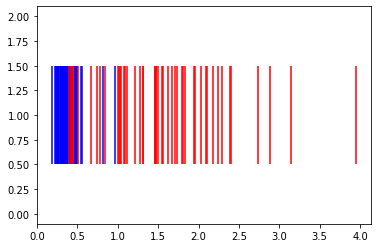

In [ ]:
plt.figure()
plt.eventplot(out_0, orientation='horizontal', colors='b')
plt.eventplot(out_1, orientation='horizontal', colors='r')
plt.show()

In [ ]:
out_0 = predict(model, criterion, val_images[-8:], batch_size=8)

In [ ]:
out_1 = predict(model, criterion, val_images_1[-8:], batch_size=8)

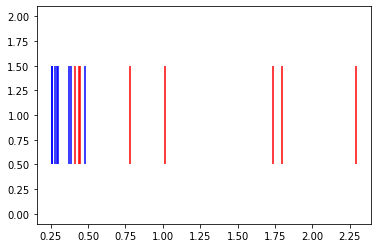

In [ ]:
plt.figure()
plt.eventplot(out_0, orientation='horizontal', colors='b')
plt.eventplot(out_1, orientation='horizontal', colors='r')
plt.show()

Вывод: По значению ошибки реконструкции оригиналы и атаки довольно хорошо разделяются.